# Can a combination of MRI scans, screening test results, and demographics from the OASIS project be early predictors of the onset of dementia?
CKME136 <br />
Alexander Wong

## Import Libraries and Data

In [1]:
import pandas as pd # For reading data and data frames
import numpy as np # For data transformation and aggregation
import seaborn as sns; sns.set() # For plots
import matplotlib.pyplot as plt # For plots
import scipy.stats # For stats (e.g. normality test)
from sklearn.cluster import KMeans # For k-Means clustering
from sklearn.feature_selection import VarianceThreshold # For low variance filter
import random; # random.seed(1)
print('Libraries loaded.')
pwd = %pwd

Libraries loaded.


In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false; // disables auto-scroll for large visualizations
}

<IPython.core.display.Javascript object>

In [3]:
# Load Data Frames
ol = pd.read_csv('C:\\Users\\thewo\\documents\\CKME136Capstone\\oasis_longitudinal.csv')
oc = pd.read_csv('C:\\Users\\thewo\\documents\\CKME136Capstone\\oasis_cross-sectional.csv')
print('Oasis Longitudinal Preview:')
ol.head()

Oasis Longitudinal Preview:


,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [4]:
print('Oasis Cross-sectional Preview:')
oc.head()

Oasis Cross-sectional Preview:


,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN
1,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN
2,OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,NaN
3,OAS1_0004_MR1,M,R,28,NaN,NaN,NaN,NaN,1588,0.803,1.105,NaN
4,OAS1_0005_MR1,M,R,18,NaN,NaN,NaN,NaN,1737,0.848,1.010,NaN


***Note: Due to the quantity of missing values in the cross-sectional data set, focus will be primarily on the longitudinal dataset.***

## Step 1: Initial Analysis

In this step, a detailed analysis of each attribute will be done to provide a better understanding of the meaning of each field. Incorrect data types, outliers, missing values, errors, attributes with low variances and imbalances in the data will be identified. The inconsistencies identified will then be treated either in this step or following steps. Relationships between attributes will also be explored, in order to understand whether there are correlations in the source data.

### Attribute Descriptions
**Subject ID:** Unique identifier for each subject being tested. <br />
**MRI ID:** Unique identifier for each MRI scanning session. <br />
**\*Group:** Label given to the subject as having dementia (labeled "Demented"), not having dementia (labeled "Nondemented"), or being converted from nondemented to demented (labeled "Converted"). This is the class variable for this project. <br />
**Visit:** The visit number for each MRI scanning session. <br />
**MR Delay:** The delay from a patient's first visit (days). <br />
**M/F:** Male or Female. <br />
**Hand:** Right handed or left handed. <br />
**Age:** Age at the time the MRI scan was acquired (years) (Marcus et al., 2010) <br />
**EDUC:** Years of education. <br />
**SES:** Socioeconomic status. This is based on the Hollingshead Index of Social Position. Categories: 1 (highest status) to 5 (lowest status) (Marcus et al., 2010) <br />
**MMSE:** Mini-Mental State Examination score (0 = worst to 30 = best) (Marcus et al., 2010) <br />
**CDR:** Clinical Dementia Rating (0 = no dementia, 0.5 = very mild dementia, 1= mild dementia, 2= moderate dementia) (Marcus et al., 2010) <br />
**eTIV:** Estimated total intracranial volume (cm^3) (Marcus et al., 2010) <br />
**nWBV:** Normalized whole-brain volume (expressed as a percentage of gray or white matter in the image processed)(Marcus et al., 2010) <br />
**ASF:** Atlas scaling factor (unitless). This field is calculated and is based on eTIV. It is a scaling factor that normalizes brain sizes to a specific target (i.e., the determinant of the transformation matrix) (Marcus et al., 2010)

\**Group is the class variable for this project*

In [5]:
# Brief description of the data
ol.describe()

,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
count,373.000000,373.000000,373.000000,373.000000,354.000000,371.000000,373.000000,373.000000,373.000000,373.000000
mean,1.882038,595.104558,77.013405,14.597855,2.460452,27.342318,0.290885,1488.128686,0.729568,1.195461
std,0.922843,635.485118,7.640957,2.876339,1.134005,3.683244,0.374557,176.139286,0.037135,0.138092
min,1.000000,0.000000,60.000000,6.000000,1.000000,4.000000,0.000000,1106.000000,0.644000,0.876000
25%,1.000000,0.000000,71.000000,12.000000,2.000000,27.000000,0.000000,1357.000000,0.700000,1.099000
50%,2.000000,552.000000,77.000000,15.000000,2.000000,29.000000,0.000000,1470.000000,0.729000,1.194000
75%,2.000000,873.000000,82.000000,16.000000,3.000000,30.000000,0.500000,1597.000000,0.756000,1.293000
max,5.000000,2639.000000,98.000000,23.000000,5.000000,30.000000,2.000000,2004.000000,0.837000,1.587000


### 1) Data Types

The raw data types from the source longitudinal data will be determined. Data types will be reviewed for each field and converted accordingly. The data types important to this research are:
- object (text)
- category (factors)
- int64 (integers)
- float64 (decimals)

#### 1.1) List raw data types

In [6]:
print(ol.dtypes)

Subject ID     object
MRI ID         object
Group          object
Visit           int64
MR Delay        int64
M/F            object
Hand           object
Age             int64
EDUC            int64
SES           float64
MMSE          float64
CDR           float64
eTIV            int64
nWBV          float64
ASF           float64
dtype: object


Subject ID and MRI ID are identifiers containing alphanumeric characters, so they will remain as objects. Group is the class variable so it will need to be treated as a category. Visit is a running count and MR Delay is a measurement in days, so they can remain as integers. M/F and Hand are categorical and can each have a possibility of 2 values, so they will be treated as categories. Age and EDUC can remain as integers as they are measurements in years. SES can only have 5 possible values so it could be treated as a category, but we may want to aggregate this field, so it will remain as a number. MMSE can be a discrete value ranging from 1-30 so it will be converted to a number. CDR, nWBV and ASF are measured with decimals so they can be kept as floats. eTIV is measured in centimeters cubed so it can be left as an integer.

#### 1.2) Convert data types

In [7]:
ol_newtype = ol.copy()
ol_newtype['Group'] = ol_newtype['Group'].astype('category')
ol_newtype['M/F'] = ol_newtype['M/F'].astype('category')
ol_newtype['Hand'] = ol_newtype['Hand'].astype('category')
ol_newtype['SES'] = ol_newtype['SES'].astype('float64')
ol_newtype['MMSE'] = ol_newtype['MMSE'].astype('float64')
print(ol_newtype.dtypes)

Subject ID      object
MRI ID          object
Group         category
Visit            int64
MR Delay         int64
M/F           category
Hand          category
Age              int64
EDUC             int64
SES            float64
MMSE           float64
CDR            float64
eTIV             int64
nWBV           float64
ASF            float64
dtype: object


### 2) Missing Data

The next stage of the initial analysis requires us to look for missing values in the dataset. The heatmap below shows that SES and MMSE contain null values. When encountering missing values, the record can be removed entirely or the missing value can be filled with the mean, median or mode of the attribute in question. In the case of SES and MMSE, we will attempt to fill the null values.

Subject ID     0
MRI ID         0
Group          0
Visit          0
MR Delay       0
M/F            0
Hand           0
Age            0
EDUC           0
SES           19
MMSE           2
CDR            0
eTIV           0
nWBV           0
ASF            0
dtype: int64

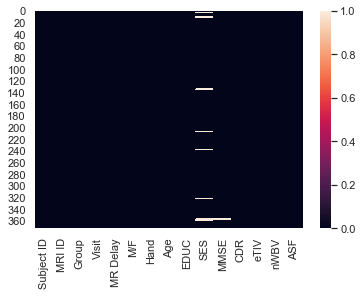

In [8]:
sns.heatmap(ol_newtype.isnull(), vmin=0, vmax=1) # Generate heatmap
ol_newtype.isna().sum() # Generate table of nulls

#### 2.1) Median SES values
For missing SES values, the median value based on years of education will be used in its place. There is an assumption being made here that the socioeconomic status of a subject is related to the years of education. This is in hopes of populating a more realistic value than just a simple median. Filtering the dataset for null SES values results in two groups: 

In [9]:
ol_null_ses = ol_newtype[ol_newtype['SES'].isna()]
print(list(set(ol_null_ses['EDUC']))) # distinct list of EDUC

[16, 12]


The output of the code shows that records with null SES values are from subjects with 12 and 16 years of education. The next step is to determine the median values for these categories. It turns out that the median SES for subjects with 12 years of education is 3. The median for subjects with 16 years of education is 2.

In [10]:
median_12 = ol_newtype.loc[ol_newtype['EDUC']==12,'SES'].median(skipna=True)
print('Education 12 years median:', median_12)
median_16 = ol_newtype.loc[ol_newtype['EDUC']==16,'SES'].median(skipna=True)
print('Education 16 years median:', median_16)

Education 12 years median: 3.0
Education 16 years median: 2.0


#### 2.2) Median MMSE value
For MMSE, an overall median will be determined and used to replace the null values.

In [11]:
median_mmse = ol_newtype['MMSE'].median(skipna=True)
print('MMSE median:', median_mmse)

MMSE median: 29.0


#### 2.3) Replace nulls with medians
In the step below, we replace missing SES values with either 3 (12 years of education) or 2 (16 years of education), and missing MMSE values with 29. Based on the new heatmap, we can see that there are no longer any missing values.

Subject ID    0
MRI ID        0
Group         0
Visit         0
MR Delay      0
M/F           0
Hand          0
Age           0
EDUC          0
SES           0
MMSE          0
CDR           0
eTIV          0
nWBV          0
ASF           0
dtype: int64

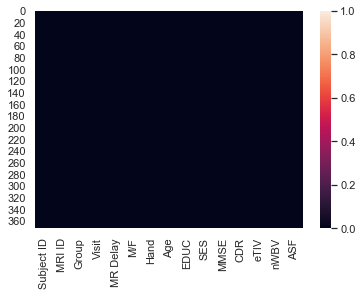

In [12]:
ol_fillna = ol_newtype.copy() # Create a copy of data frame

# Fill missing values
ol_fillna.loc[ol_fillna['EDUC']==12, 'SES'] = ol_fillna.loc[ol_fillna['EDUC']==12, 'SES'].fillna(median_12)
ol_fillna.loc[ol_fillna['EDUC']==16, 'SES'] = ol_fillna.loc[ol_fillna['EDUC']==16, 'SES'].fillna(median_16)
ol_fillna['MMSE'] = ol_fillna['MMSE'].fillna(median_16)

sns.heatmap(ol_fillna.isnull(), vmin=0, vmax=1) # Generate Heatmap
ol_fillna.isna().sum() # Generate table of nulls

### 3) Further Errors and Inconsistencies

A visual scan of the Subject ID and MRI ID show that there are no obvious errors or inconsistencies. Printing a list of distinct values for the two categorical attributes, Group and M/F, also return the expected results. It should be noted that further inconsistencies could surface at later points of the analysis. 

In [13]:
print(list(set(ol_fillna['Group'])))

['Converted', 'Demented', 'Nondemented']


In [14]:
print(list(set(ol_fillna['M/F'])))

['F', 'M']


### 4) Outliers Analysis

#### 4.1) Boxplots

Boxplots help to visualize the distribution of data points for a given numerical attribute. Boxplots summarize the median, first quartile, third quartile, and minimum/maximum value of the data points within 1.5 times the interquartile range (third quartile - first quartile). The boxplot can be used to locate data points that vary from the rest, commonly referred to as outliers. These are typically values that lie outside the minimum/maximum range on the graph. In this exercise, boxplots will be generated for all integer and float attributes.

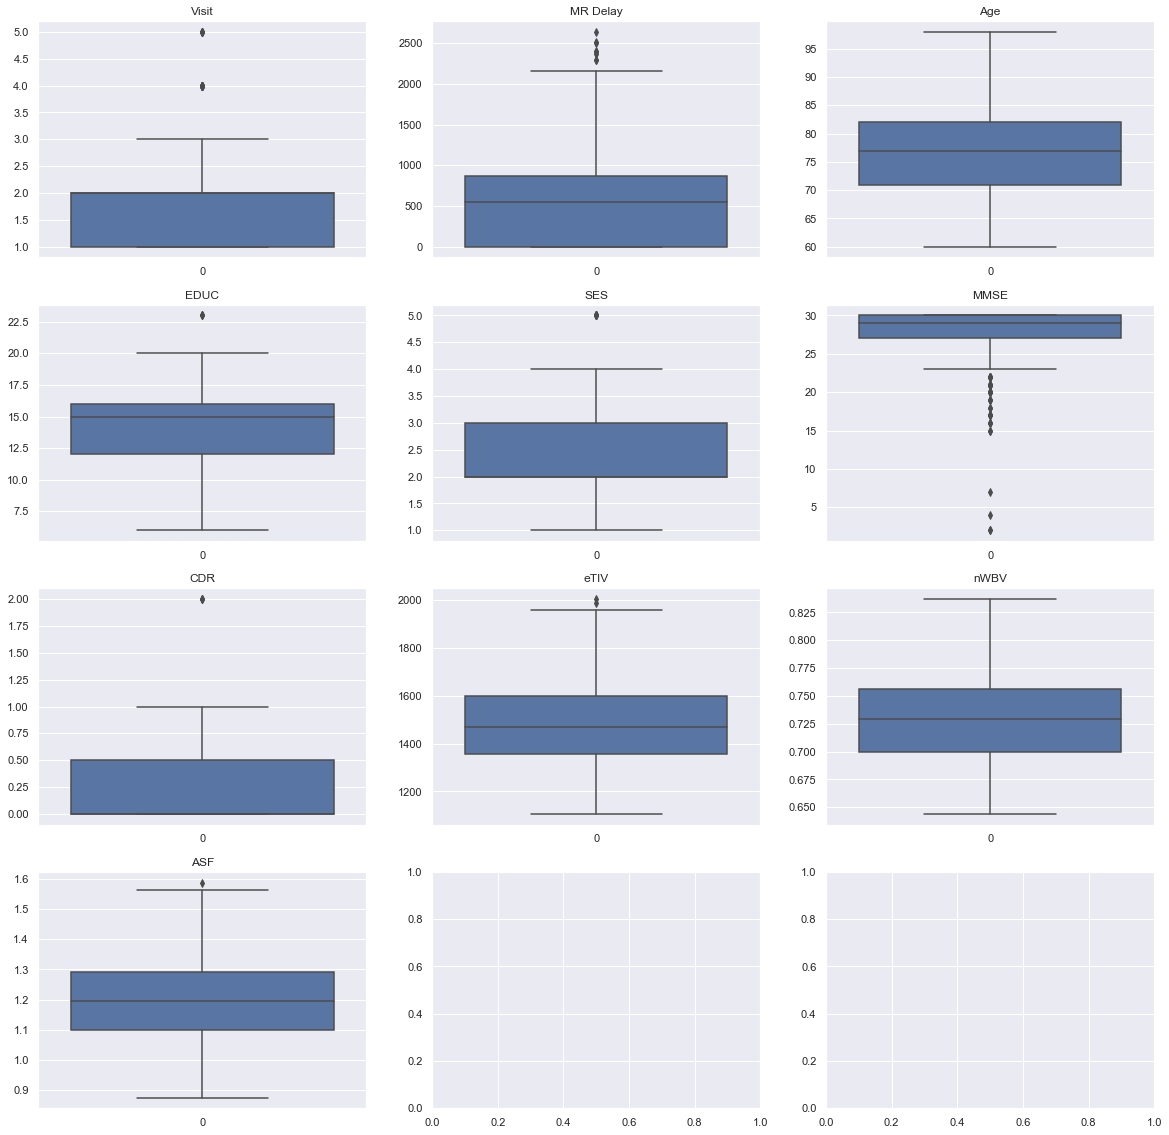

In [15]:
# Create the subplot
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20,20))

# Create boxplots of each attribute and set on the subplot
b1 = sns.boxplot(data = ol_fillna['Visit'], ax=axes[0,0])
b1.title.set_text('Visit')
b2 = sns.boxplot(data = ol_fillna['MR Delay'], ax=axes[0,1])
b2.title.set_text('MR Delay')
b3 = sns.boxplot(data = ol_fillna['Age'], ax=axes[0,2])
b3.title.set_text('Age')
b4 = sns.boxplot(data = ol_fillna['EDUC'], ax=axes[1,0])
b4.title.set_text('EDUC')
b5 = sns.boxplot(data = ol_fillna['SES'], ax=axes[1,1])
b5.title.set_text('SES')
b6 = sns.boxplot(data = ol_fillna['MMSE'], ax=axes[1,2])
b6.title.set_text('MMSE')
b7 = sns.boxplot(data = ol_fillna['CDR'], ax=axes[2,0])
b7.title.set_text('CDR')
b8 = sns.boxplot(data = ol_fillna['eTIV'], ax=axes[2,1])
b8.title.set_text('eTIV')
b9 = sns.boxplot(data = ol_fillna['nWBV'], ax=axes[2,2])
b9.title.set_text('nWBV')
b10 = sns.boxplot(data = ol_fillna['ASF'], ax=axes[3,0])
b10.title.set_text('ASF')

With the boxplots, it can be visually determined that the following attributes may have outliers:
- Visit
- EDUC
- SES
- MMSE
- CDR

In order to confirm our suspicions, histograms can be used to gain an alternate perspective on these attributes.

#### 4.2) Histograms

Histograms are another visual used to look at the distribution of data points of an attribute. Histograms plot the frequency of occurrences for each value of a numerical attribute. Compared to boxplots, one can more clearly see the distribution of an attribute. Histograms will be used to validate the attributes that we believe have outliers.

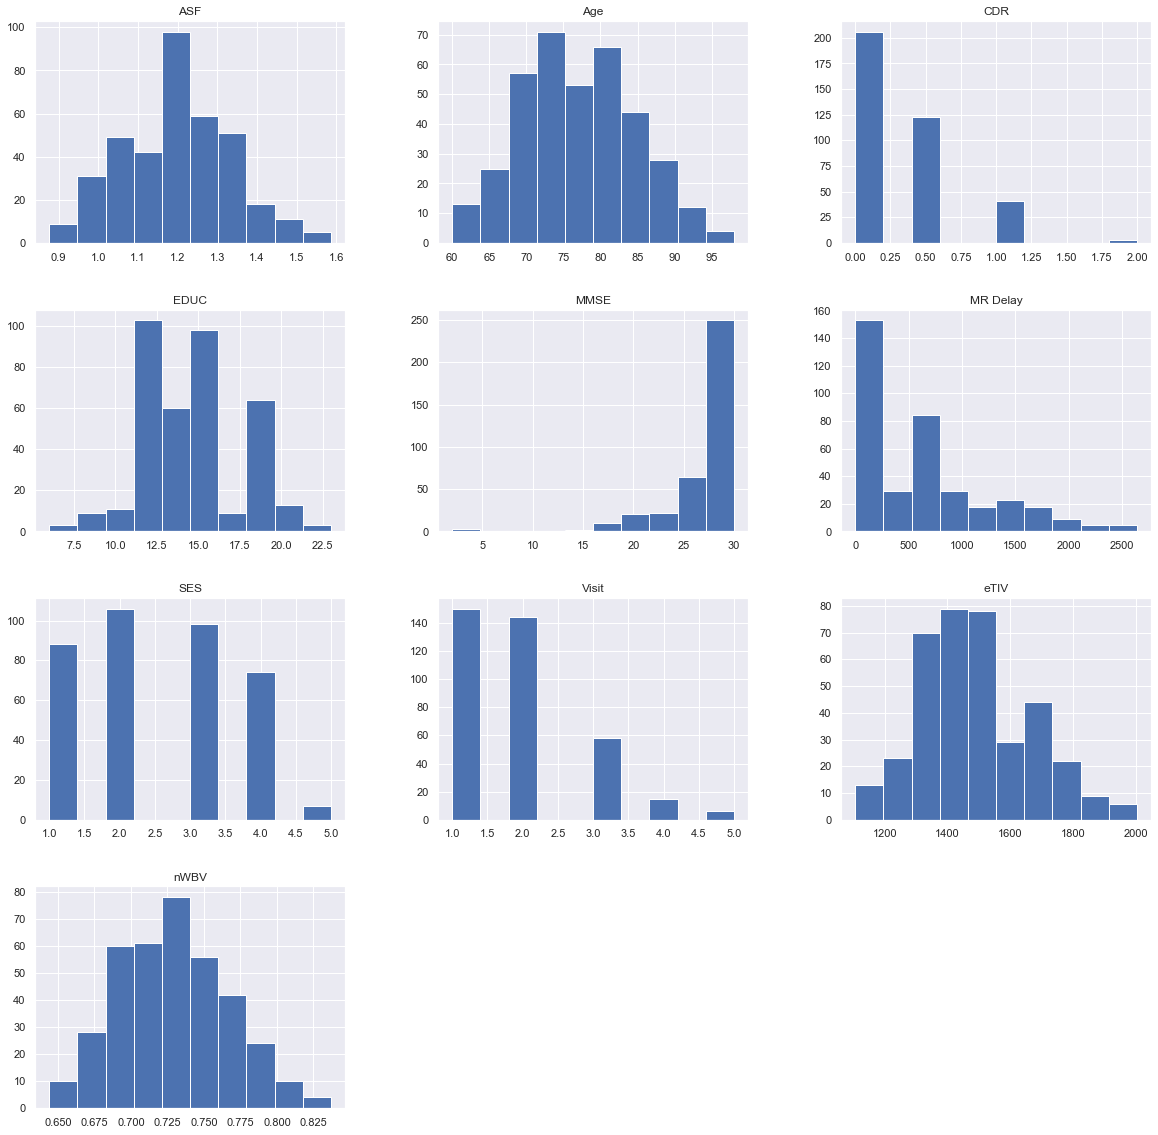

In [16]:
# Create histograms
histograms = ol_fillna.hist(layout=(4,3), figsize=(20,20))

Further analysis with the histograms indicate that there is no sufficient evidence proving the existence of outliers. This is because none of the data points fall significantly far from their distributions. Therefore, the decision has been made not to remove any values that were previously believed to be outliers.

### 5) Class Variable Imbalance
The purpose of this step is to determine whether there is an imbalance in the class variable, Group. The goal is to determine whether there are significantly more records of one value over another. Since there are only 3 possible classes, an imbalance can be easily visualized and determined with a pie chart and/or pivot table.

In [17]:
class_imbalance = pd.pivot_table(ol_fillna, index='Group', values='MRI ID', aggfunc=len)
class_imbalance

,MRI ID
Group,
Converted,37
Demented,146
Nondemented,190


Pie Chart:


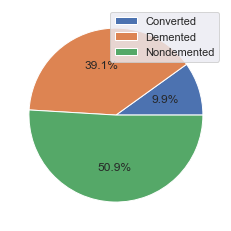

In [18]:
print('Pie Chart:')

pivot = class_imbalance.reset_index() # Convert pivot table to a data frame
labels = pivot.loc[:,'Group']
values = pivot.loc[:,'MRI ID']
patches, text, lab = plt.pie(values, autopct='%.1f%%') # Create the pie chart with value labels
plt.legend(patches, labels) # Create legend
plt.show()

Considering that the 'Converted' subjects are technically 'Demented', it can be said that the class variable is balanced (183 Demented vs. 190 Nondemented). Therefore, no balancing is required. In later steps, we may want to re-label 'Converted' subjects to 'Demented'.

### 6) Bivariate Analysis
The purpose of the bivariate analysis is to identify pairwise relationships between 2 variables. The most common practice in this step is to look at scatter plots as they provide a visual representation of the correlation between 2 variables. Correlation analysis should also be carried out to statistically determine if a relationship truly exists between 2 variables.

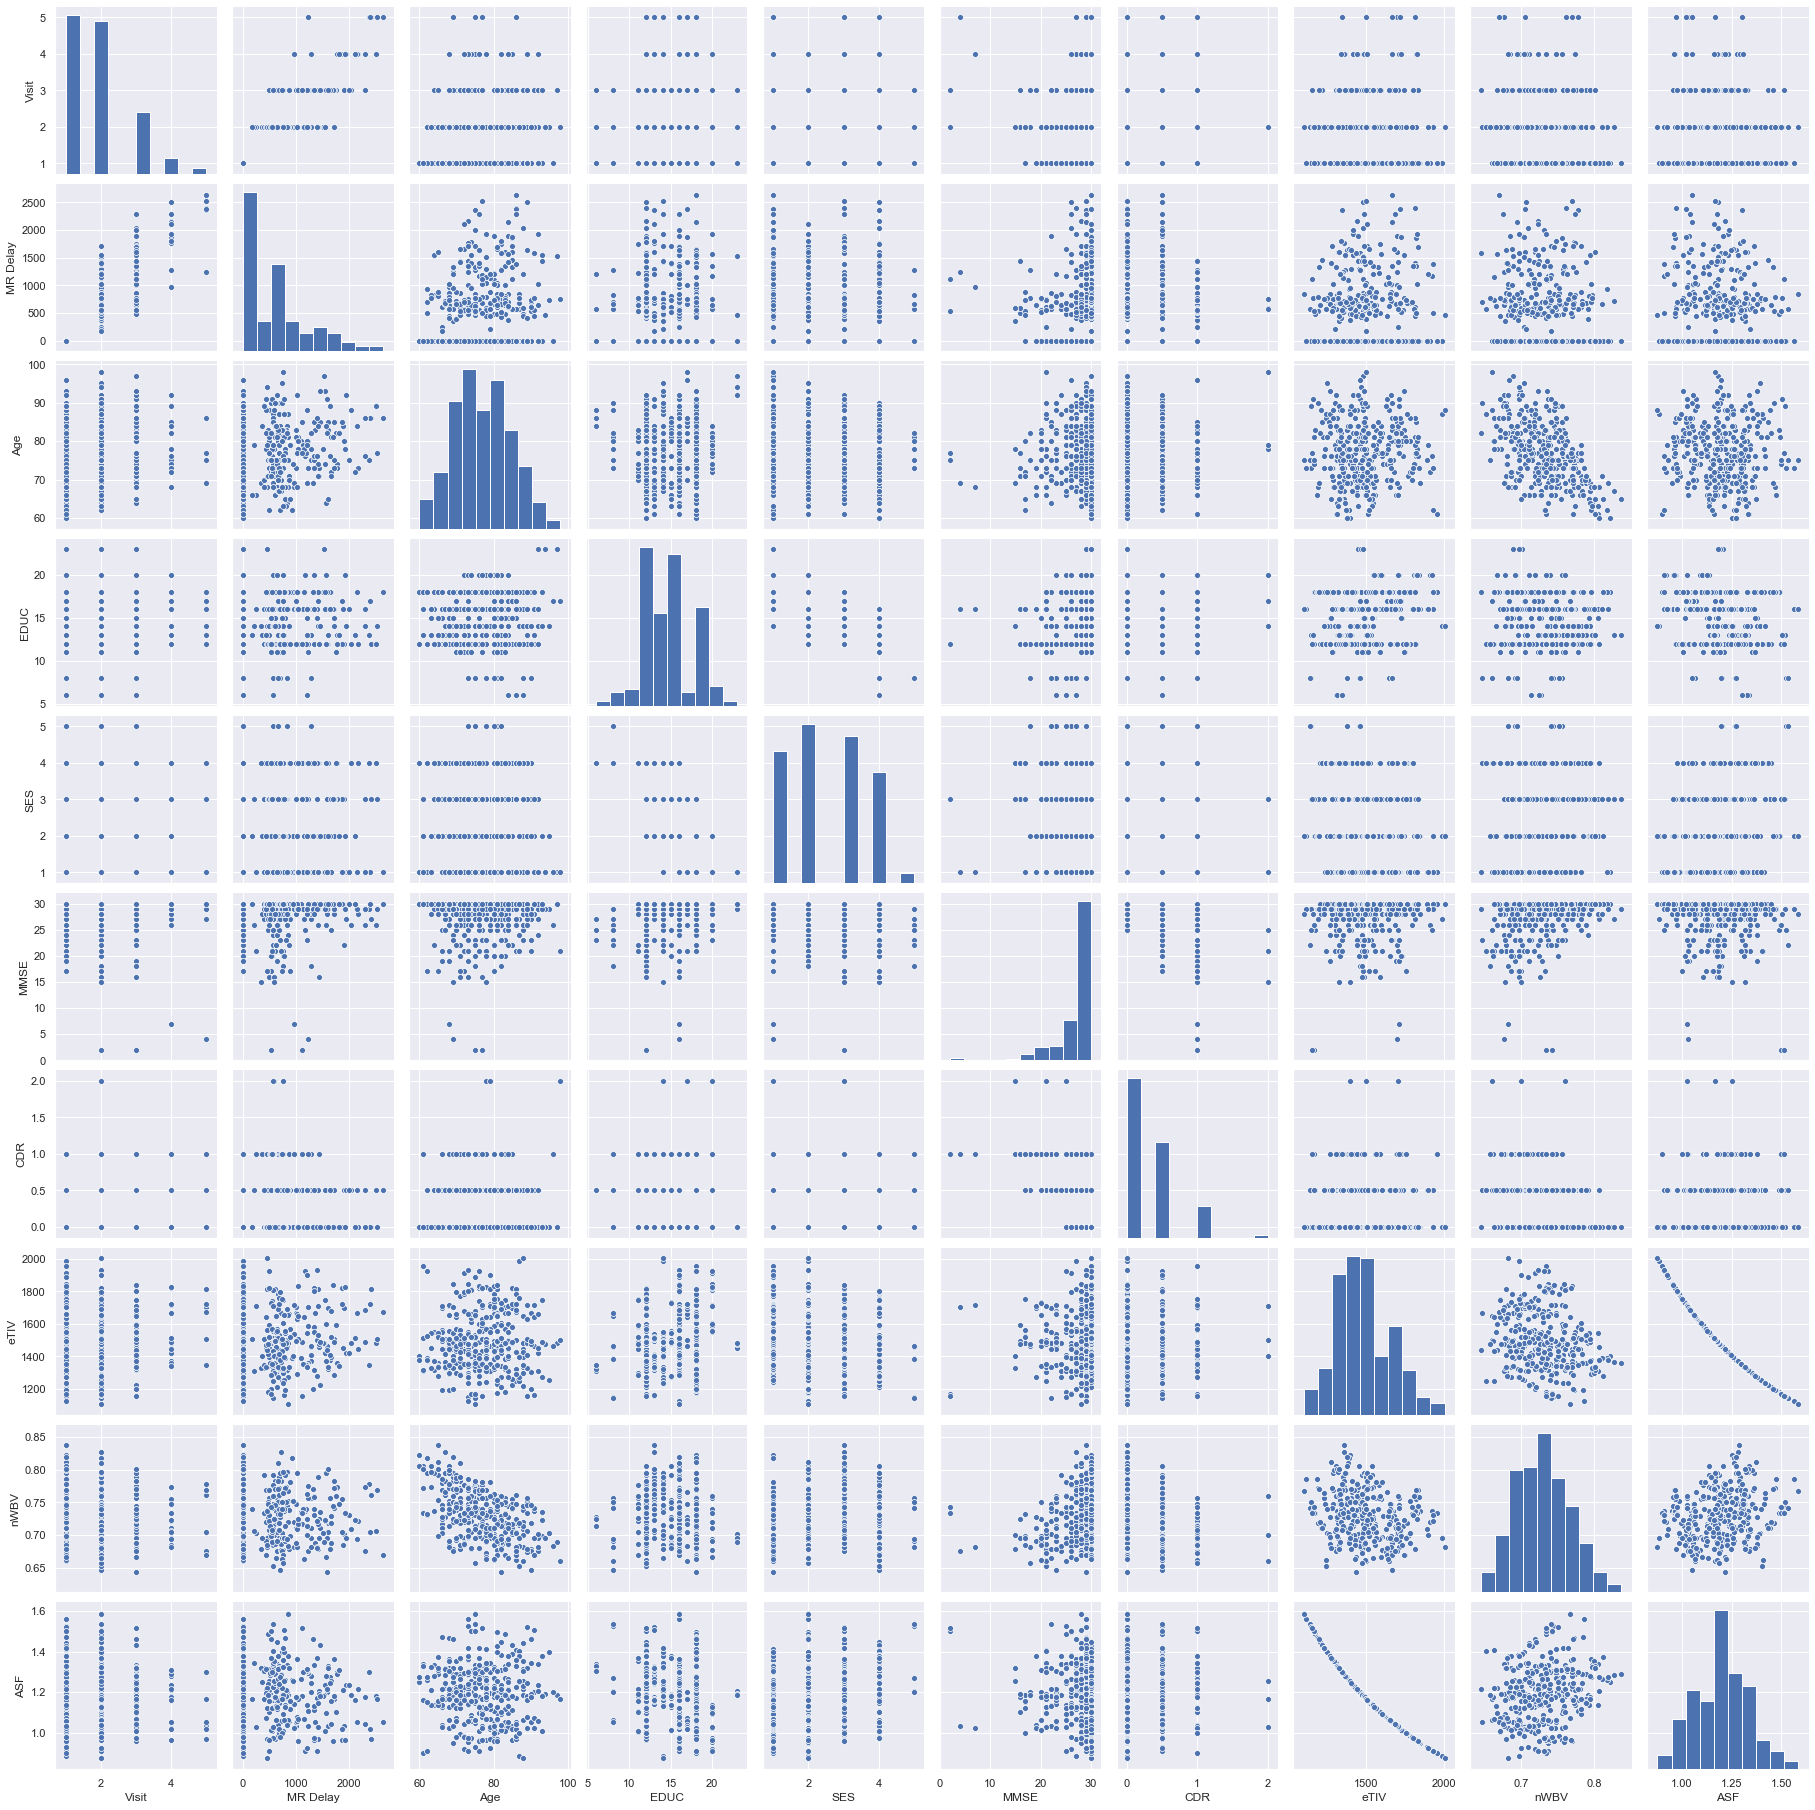

In [19]:
# Create pairplot
sns.pairplot(ol_fillna)

The pairplot provides a visual of how each attribute relates to the other. The noteworthy relationships to point out are:
- Age and Normalized Whole Brain Volume (nWBV)
- Socioeconomic Status (SES) and Education (EDUC)
- Normalized Whole Brain Volume (nWBV) and Estimated Total Intracranial Volume (eTIV)
- Normalized Whole Brain Volume (nWBV) and Atlast Scaling Factor (ASF)
- Estimated Total Intracranial Volume and Atlast Scaling Factor (ASF)

To confirm the validity of the above claims, correlation must be determined. The output of a correlation analysis will be a number between -1 and 1, and provides insights into the type of relationship (positive or negative) and how strong the relationship is. Prior to conducting a correlation analysis, it is important to test the normality of the data in order to understand whether to apply the pearson test (parametric) or spearman test (non-parametric).

In [20]:
# Conduct normality test
k2, p = scipy.stats.normaltest(ol_fillna['Visit'])
print("p_visit = {:g}".format(p))
k2, p = scipy.stats.normaltest(ol_fillna['MR Delay'])
print("p_mrdelay = {:g}".format(p))
k2, p = scipy.stats.normaltest(ol_fillna['Age'])
print("p_age = {:g}".format(p))
k2, p = scipy.stats.normaltest(ol_fillna['EDUC'])
print("p_educ = {:g}".format(p))
k2, p = scipy.stats.normaltest(ol_fillna['SES'])
print("p_ses = {:g}".format(p))
k2, p = scipy.stats.normaltest(ol_fillna['MMSE'])
print("p_mmse = {:g}".format(p))
k2, p = scipy.stats.normaltest(ol_fillna['CDR'])
print("p_cdr = {:g}".format(p))
k2, p = scipy.stats.normaltest(ol_fillna['eTIV'])
print("p_etiv = {:g}".format(p))
k2, p = scipy.stats.normaltest(ol_fillna['nWBV'])
print("p_nwbv = {:g}".format(p))
k2, p = scipy.stats.normaltest(ol_fillna['ASF'])
print("p_asf = {:g}".format(p))

p_visit = 4.46715e-13
p_mrdelay = 4.24223e-10
p_age = 0.0768767
p_educ = 0.977357
p_ses = 2.6456e-19
p_mmse = 1.73602e-55
p_cdr = 1.3394e-20
p_etiv = 0.000729656
p_nwbv = 0.0234679
p_asf = 0.514103


The null hypothesis here is that each attribute is normally distributed. Attributes that return  a p-value less than 0.05 from the normality test will reject the null hypothesis, meaning that they are considered not to be normally distributed. Based on the results above, Age, Education, and Atlas Scaling Factor are the only attributes that can be considered normally distributed. Because of this, we will assume that the data is non-parametric and thus use the Spearman correlation test for the correlation matrix.

In [21]:
corr = ol_fillna.corr(method='spearman') # Correlation matrix
corr.style.background_gradient(cmap='coolwarm').set_precision(2) # Styling

,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
Visit,1.00,0.94,0.19,0.03,-0.05,0.04,0.01,0.11,-0.14,-0.11
MR Delay,0.94,1.00,0.19,0.06,-0.04,0.08,-0.04,0.11,-0.11,-0.11
Age,0.19,0.19,1.00,-0.05,-0.04,-0.03,-0.04,0.05,-0.48,-0.05
EDUC,0.03,0.06,-0.05,1.00,-0.73,0.24,-0.21,0.23,-0.01,-0.23
SES,-0.05,-0.04,-0.04,-0.73,1.00,-0.20,0.12,-0.24,0.10,0.24
MMSE,0.04,0.08,-0.03,0.24,-0.20,1.00,-0.68,0.02,0.28,-0.02
CDR,0.01,-0.04,-0.04,-0.21,0.12,-0.68,1.00,0.03,-0.36,-0.03
eTIV,0.11,0.11,0.05,0.23,-0.24,0.02,0.03,1.00,-0.21,-1.00
nWBV,-0.14,-0.11,-0.48,-0.01,0.10,0.28,-0.36,-0.21,1.00,0.21
ASF,-0.11,-0.11,-0.05,-0.23,0.24,-0.02,-0.03,-1.00,0.21,1.00


The correlation matrix indicates that there is a strong positive correlation between MR Delay and Visit. This makes sense because the delay from the first visit naturally increases as the subject takes part in further visits. The matrix also indicates a strong negative correlation between Education (EDUC) and Socioeconomic Status (SES). This falls in line with our prior hypothesis when filling in missing SES values, that a higher level of education tends to lead to higher socioeconomic status. The matrix also points out a very strong negative correlation between the Estimated Total Intracranial Volume (eTIV) and the Atlas Scaling Factor (ASF). This is because the Atlas Scaling Factor is a calculated value that is actually based on Estimated Total Intracranial Volume. This will be noted for the Dimensionality Reduction step as Atlas Scaling Factor can likely be dropped. Another relationship to point out from the matrix is between Mini-Mental State Exam (MMSE) and Clinical Dementia Rating (CDR). The negative correlation between the two variables suggests that, as we would expected, a lower score on the Mini-Mental State Exam correlates to a higher likelihood of having dementia. Lastly, the matrix shows that there is a moderate negative correlation between Age and Normalized Whole Brain Volume. This could suggest that brain matter decays as one gets older.

## Step 2: Exploratory Data Analysis
In the Exploratory Analysis step, we will look at subsetting the data in different ways to understand if there are patterns or trends between attributes. Numerical value fields in the data set will also be normalized to a common scale. Furthermore, methods of clustering may be applied to determine if there are any logical groupings in the data.

### 1) Sub-setting


#### 1.1) Subject handedness:

In [22]:
# Pivot on handedness
pd.pivot_table(ol_fillna, index='Hand', values='Subject ID', aggfunc=lambda x: len(x.unique()))

,Subject ID
Hand,
R,150


All subjects are right-handed, therefore, this column could be removed in later steps due to no variance. <br />
#### 1.2) MMSE scores by Group:

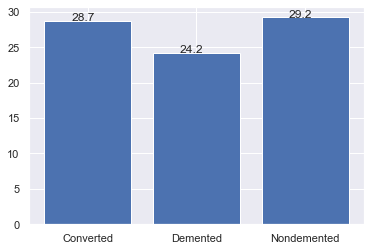

In [23]:
# Create pivot
mmse_by_group = pd.pivot_table(ol_fillna, index='Group', values=['MMSE'], aggfunc={'MMSE':np.mean})
pivot = mmse_by_group.reset_index() # Convert pivot to data frame

# Create bar chart
x = pivot['Group']
y = pivot['MMSE']
bars = plt.bar(x,y)
for bar in bars: # Add value labels
    yval = round(bar.get_height(),1)
    plt.text(bar.get_x()+0.25, yval + .005, yval)   
plt.show()

As expected, Nondemented subjects, on average, score higher on the Mini-Mental State Exam than the group of Demented subjects. The group of Converted subjects still scored high, potentially meaning the onset of Dementia could still be in the early stages. It is worth sub-setting and investigating the Converted Group further. <br />
#### 1.3) Subsetting 'Converted' patients

In [24]:
# Filter on converted subjects
print('Filter on converted subjects:')
ol_fillna.loc[ol_fillna['Group']=="Converted",:].head()

Filter on converted subjects:


,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
33,OAS2_0018,OAS2_0018_MR1,Converted,1,0,F,R,87,14,1.0,30.0,0.0,1406,0.715,1.248
34,OAS2_0018,OAS2_0018_MR3,Converted,3,489,F,R,88,14,1.0,29.0,0.0,1398,0.713,1.255
35,OAS2_0018,OAS2_0018_MR4,Converted,4,1933,F,R,92,14,1.0,27.0,0.5,1423,0.696,1.234
36,OAS2_0020,OAS2_0020_MR1,Converted,1,0,M,R,80,20,1.0,29.0,0.0,1587,0.693,1.106
37,OAS2_0020,OAS2_0020_MR2,Converted,2,756,M,R,82,20,1.0,28.0,0.5,1606,0.677,1.093


In [25]:
# Filter on a single converted subject
print('Filter on a single converted subject:')
ol_fillna.loc[ol_fillna['Subject ID']=="OAS2_0018",:]

Filter on a single converted subject:


,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
33,OAS2_0018,OAS2_0018_MR1,Converted,1,0,F,R,87,14,1.0,30.0,0.0,1406,0.715,1.248
34,OAS2_0018,OAS2_0018_MR3,Converted,3,489,F,R,88,14,1.0,29.0,0.0,1398,0.713,1.255
35,OAS2_0018,OAS2_0018_MR4,Converted,4,1933,F,R,92,14,1.0,27.0,0.5,1423,0.696,1.234


Further subsetting of the Converted group shows that in the initial visit, the subjects are still labeled as converted, even though they are supposed to be 'Nondemented'. Therefore, in later steps the first visit for each subject in the 'Converted' Group should be modified to 'Nondemented'. <br />
#### 1.4) MMSE by Clinical Dementia Rating
I wanted to understand if there was a relationship beyond Clinical Dementia Rating (CDR) and the Mini-Mental State Exam (MMSE) results, thus I decided to incorporate Normalized Whole Brain Volume (nWBV) into a scatter chart.

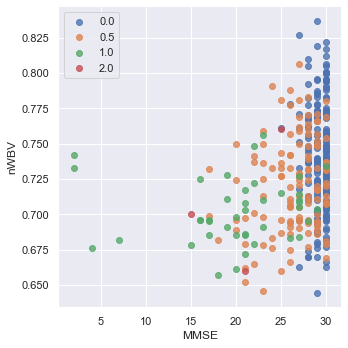

In [26]:
sns.lmplot('MMSE','nWBV', data=ol_fillna, fit_reg=False, hue='CDR', legend=False) # Create scatter
plt.legend(loc='upper left') # Position legend

The results are mostly inconclusive, but there are a few points to note. All subjects with a Clinical Dementia Rating of 0 have an MMSE score consistently above 25. Subjects with CDR greater than 0 are more spread in terms of MMSE score results. Another point to highlight is that subjects with a CDR greater or equal to 1, have consistently smaller Normalized Whole Brain Volumes.

### 2) Normalization
Certain machine learning algorithms base results on distance measures, therefore the data must be normalized. The process of normalization converts numerical attributes to a scale between 0 and 1.

In [27]:
# Create a copy of data frame
ol_norm = ol_fillna.copy()

# Plug attribute names into normalization formula
X = 'Visit'
ol_norm[X] = (ol_norm[X] - ol_norm[X].min()) / (ol_norm[X].max() - ol_norm[X].min())
X = 'MR Delay'
ol_norm[X] = (ol_norm[X] - ol_norm[X].min()) / (ol_norm[X].max() - ol_norm[X].min())
X = 'Age'
ol_norm[X] = (ol_norm[X] - ol_norm[X].min()) / (ol_norm[X].max() - ol_norm[X].min())
X = 'EDUC'
ol_norm[X] = (ol_norm[X] - ol_norm[X].min()) / (ol_norm[X].max() - ol_norm[X].min())
X = 'SES'
ol_norm[X] = (ol_norm[X] - ol_norm[X].min()) / (ol_norm[X].max() - ol_norm[X].min())
X = 'MMSE'
ol_norm[X] = (ol_norm[X] - ol_norm[X].min()) / (ol_norm[X].max() - ol_norm[X].min())
X = 'CDR'
ol_norm[X] = (ol_norm[X] - ol_norm[X].min()) / (ol_norm[X].max() - ol_norm[X].min())
X = 'eTIV'
ol_norm[X] = (ol_norm[X] - ol_norm[X].min()) / (ol_norm[X].max() - ol_norm[X].min())
X = 'nWBV'
ol_norm[X] = (ol_norm[X] - ol_norm[X].min()) / (ol_norm[X].max() - ol_norm[X].min())
X = 'ASF'
ol_norm[X] = (ol_norm[X] - ol_norm[X].min()) / (ol_norm[X].max() - ol_norm[X].min())

print('Normalized dataset:')
ol_norm.head()

Normalized dataset:


,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,0.00,0.000000,M,R,0.710526,0.470588,0.25,0.892857,0.00,0.981069,0.269430,0.009845
1,OAS2_0001,OAS2_0001_MR2,Nondemented,0.25,0.173172,M,R,0.736842,0.470588,0.25,1.000000,0.00,1.000000,0.191710,0.000000
2,OAS2_0002,OAS2_0002_MR1,Demented,0.00,0.000000,M,R,0.394737,0.352941,0.50,0.750000,0.25,0.636971,0.476684,0.239100
3,OAS2_0002,OAS2_0002_MR2,Demented,0.25,0.212202,M,R,0.421053,0.352941,0.50,0.928571,0.25,0.703786,0.357513,0.188467
4,OAS2_0002,OAS2_0002_MR3,Demented,0.50,0.718075,M,R,0.526316,0.352941,0.50,0.714286,0.25,0.659243,0.295337,0.222222


### 3) K-Means Clustering
K-Means clustering is used to determine the optimal grouping of a set of numerical data. It can be used to identify different groups of subjects in the MRI data. K-Means clustering will be applied on the normalized set of numerical attributes in the dataset. The results will then need to be denormalized in order to interpret the results.

In [28]:
# Create copy of data frame
ol_clust = ol_norm.copy()

# Remove non-numeric attributes
ol_clust = ol_clust.drop(['Subject ID', 'MRI ID', 'Group', 'M/F', 'Hand'], axis=1)
ol_clust.head()

,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,0.00,0.000000,0.710526,0.470588,0.25,0.892857,0.00,0.981069,0.269430,0.009845
1,0.25,0.173172,0.736842,0.470588,0.25,1.000000,0.00,1.000000,0.191710,0.000000
2,0.00,0.000000,0.394737,0.352941,0.50,0.750000,0.25,0.636971,0.476684,0.239100
3,0.25,0.212202,0.421053,0.352941,0.50,0.928571,0.25,0.703786,0.357513,0.188467
4,0.50,0.718075,0.526316,0.352941,0.50,0.714286,0.25,0.659243,0.295337,0.222222


In [29]:
# Run k-Means with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(ol_clust)
y_kmeans = kmeans.predict(ol_clust)

# Produce cluster centers
results = kmeans.cluster_centers_
clusters = pd.DataFrame(data=results[0:, 0:], index=['Cluster 1', 'Cluster 2', 'Cluster 3'],columns=['Visit', 'MR Delay', 'Age', 'EDUC', 'SES','MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF'])

# De-normalize the values
X = 'Visit'
clusters[X] = (ol_fillna[X].max() - ol_fillna[X].min()) * clusters[X] + ol_fillna[X].min()
X = 'MR Delay'
clusters[X] = (ol_fillna[X].max() - ol_fillna[X].min()) * clusters[X] + ol_fillna[X].min()
X = 'Age'
clusters[X] = (ol_fillna[X].max() - ol_fillna[X].min()) * clusters[X] + ol_fillna[X].min()
X = 'EDUC'
clusters[X] = (ol_fillna[X].max() - ol_fillna[X].min()) * clusters[X] + ol_fillna[X].min()
X = 'SES'
clusters[X] = (ol_fillna[X].max() - ol_fillna[X].min()) * clusters[X] + ol_fillna[X].min()
X = 'MMSE'
clusters[X] = (ol_fillna[X].max() - ol_fillna[X].min()) * clusters[X] + ol_fillna[X].min()
X = 'CDR'
clusters[X] = (ol_fillna[X].max() - ol_fillna[X].min()) * clusters[X] + ol_fillna[X].min()
X = 'eTIV'
clusters[X] = (ol_fillna[X].max() - ol_fillna[X].min()) * clusters[X] + ol_fillna[X].min()
X = 'nWBV'
clusters[X] = (ol_fillna[X].max() - ol_fillna[X].min()) * clusters[X] + ol_fillna[X].min()
X = 'ASF'
clusters[X] = (ol_fillna[X].max() - ol_fillna[X].min()) * clusters[X] + ol_fillna[X].min()

# Show cluster results in tabular form
clusters

,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
Cluster 1,1.500000,336.023437,76.468750,16.750000,1.523438,27.906250,0.230469,1564.375000,0.728445,1.135531
Cluster 2,3.347826,1608.623188,79.637681,15.260870,2.173913,28.217391,0.188406,1553.028986,0.723913,1.143116
Cluster 3,1.585227,386.181818,76.380682,12.772727,3.295455,26.301136,0.375000,1407.232955,0.732602,1.259568


The result of the K-Means clustering returns 3 different groups of subjects. While there are some similarities between clusters, there are attributes that delineate clear differences. For the attribute Visit, the values for Cluster 1 (1.5) and Cluster 3 (1.58) could infer 1-2 visits, while the value of Cluster 2 (3.34) could represent 3 or more visits. For MR Delay, the values of Cluster 1 (336.02) and Cluster 3 (386.18) could represent 1 year delay between visits, while Cluster 2 (1608.62) could represent 4-5 years. For Education, it could be assumed that Cluster 1 (16.75) and Cluster 2 (15.26) indicate post-secondary level education, while Cluster 3 (12.77) indicates high school level education. Each of the Socioeconomic values for Cluster 1 (1.52), Cluster 2 (2.17) and Cluster 3 (3.29), could represent upper class, upper-middle class, and middle class respectively. For estimated total intracranial volume, it can be assumed that the values for Cluster 1 (1564.38) and Cluster 2 (1553.03) are average, while the value for cluster 3 (1407.23) is below average. For the remaining attributes, Age, MMSE, CDR, nWBV and ASF, the values between clusters are largely similar, thus they will be ignored in the group classification process.

The final clusters are are as follows:

- **Cluster 1**: Subjects with 1-2 visits within 1 year, who have a post-secondary education, who are upper class and have an average intracranial volume.
- **Cluster 2**: Subjects with 3+ visits within 4-5 years, who have a post-secondary education, who are upper-middle class and have an average intracranial volume.
- **Cluster 3**: Subjects with 1-2 visits within 1 year, who have a high school education, who are middle class and have a less than average intracranial volume.

## Step 3: Dimensionality Reduction

### Low Variance Filter

In [30]:
X = [[0, 0, 1], [0, 1, 0], [1, 0, 0], [0, 1, 1], [0, 1, 0], [0, 1, 1]]
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel.fit_transform(X)
# array([[0, 1],
#        [1, 0],
#        [0, 0],
#        [1, 1],
#        [1, 0],
#        [1, 1]])

array([[0, 1],
       [1, 0],
       [0, 0],
       [1, 1],
       [1, 0],
       [1, 1]])

In [31]:
ol_lowvar = ol_fillna.copy()
X = ol_lowvar[['Visit','MR Delay','Age','EDUC','SES','MMSE','CDR','eTIV','nWBV', 'ASF']]
T = .08
sel = VarianceThreshold(threshold=(T*(1-T)))
sel.fit_transform(X)
X.loc[:, sel.get_support()]

,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV
0,1,0,87,14,2.0,27.0,0.0,1987
1,2,457,88,14,2.0,30.0,0.0,2004
2,1,0,75,12,3.0,23.0,0.5,1678
3,2,560,76,12,3.0,28.0,0.5,1738
4,3,1895,80,12,3.0,22.0,0.5,1698
...,...,...,...,...,...,...,...,...
368,2,842,82,16,1.0,28.0,0.5,1693
369,3,2297,86,16,1.0,26.0,0.5,1688
370,1,0,61,13,2.0,30.0,0.0,1319
371,2,763,63,13,2.0,30.0,0.0,1327


## References

Marcus, D. S., Fotenos, A. F., Csernansky, J. G., Morris, J. C., & Buckner, R. L. (2010). Open
    Access Series of Imaging Studies: Longitudinal MRI Data in Nondemented and
    Demented Older Adults. Journal of Cognitive Neuroscience, 22(12), 2677-2684. doi:
    10.1162/jocn.2009.21407